# Calculate sigmav vs. mDM for simulated DM datasets

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from gammapy.astro.darkmatter.utils import SigmaVEstimator
from gammapy.spectrum import SpectrumDatasetOnOff, CountsSpectrum
from gammapy.astro.darkmatter import DarkMatterAnnihilationSpectralModel
from gammapy.irf import load_cta_irfs

## Define parameters for simulated observation

In [2]:
# -
livetime = 100 * u.h # in hours
offset = 0.5 * u.deg
FOVLON=0 * u.deg
FOVLAT=0 * u.deg

# Energy from 0.01 to 100 TeV with 20 bins/decade
energy = np.logspace(-1.8, 1.5, 20) * u.TeV

# Energy true wider range and higher number of bins
#energy_true = np.logspace(-2, 2, 100) * u.TeV

# DMAnnihilation Model
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # point source
mDM = 5000*u.Unit("GeV")
channel = "b"
redshift = 0

## Build IRFs with the defined parameters

In [3]:
# Load IRFs
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
cta_irf = load_cta_irfs(filename)

NDDataArray summary info
MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 5371581.000 m2



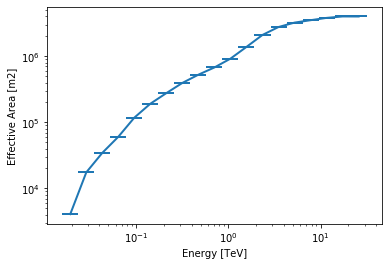

In [4]:
aeff = cta_irf["aeff"].to_effective_area_table(offset=offset, energy=energy)
aeff.plot()
plt.loglog()
print(cta_irf["aeff"].data)

## Build the background counts from PSF and IRF background

In [5]:
containment = 0.68
energies = np.sqrt(energy[1:] * energy[:-1])
psf = cta_irf["psf"].to_energy_dependent_table_psf(theta=offset)
on_radii = psf.containment_radius(energy=energies, fraction=containment)
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

#
aeff.data.data *= containment

In [6]:
bkg_data = cta_irf["bkg"].evaluate_integrate(
    fov_lon=FOVLON, fov_lat=FOVLAT, energy_reco=energy
)
bkg = CountsSpectrum(
    energy[:-1],
    energy[1:],
    data=(bkg_data * solid_angles).to_value("h-1")*livetime
)

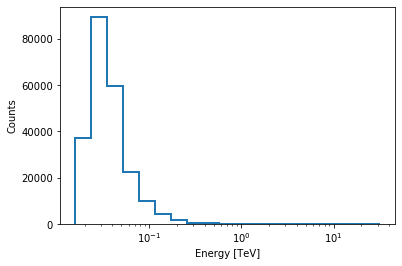

In [7]:
bkg.plot_hist()

## Simulate OnOff observation with DM emission model

In [8]:
from gammapy.modeling import Fit
from gammapy.modeling import Parameter

class DMDatasetOnOff(SpectrumDatasetOnOff):
    
    def __init__(self, nuissance, **kwargs):
        super().__init__(**kwargs)
        self.parameters.parameters
        self.nuissance = nuissance
    
    def likelihood(self):
        wstat = super().likelihood()
        liketotal = wstat * self.jnuissance()
        #liketotal = wstat * self.nuissance["j"].value
        return liketotal
    
    def jnuissance(self):
        exp_up = (np.log10(self.nuissance["j"].value) - np.log10(self.nuissance["jobs"].value))**2
        exp_down = 2*(self.nuissance["sigmaj"].value**2)
        up = np.exp(-1*exp_up/exp_down)
        down = np.log(10)*self.nuissance["jobs"].value*np.sqrt(2*np.pi)*self.nuissance["sigmaj"].value
        res = up/down
        #print(self.nuissance["j"].value, res)
        #print(up, down, res)
        return res
    
    def set_j(self, j):
        self.nuissance["j"] = j

In [9]:
# DM Flux
flux_model = DarkMatterAnnihilationSpectralModel(
    mass=mDM, 
    channel=channel, 
    jfactor=JFAC, 
    z=redshift
)

In [10]:
nuissance = dict(
    j=JFAC,
    jobs=JFAC,
    sigmaj=0.1*JFAC
)    
dataset = DMDatasetOnOff(
    nuissance=nuissance,
    aeff=aeff,
    model=flux_model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)  

1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39
1.4899977724326588e-39


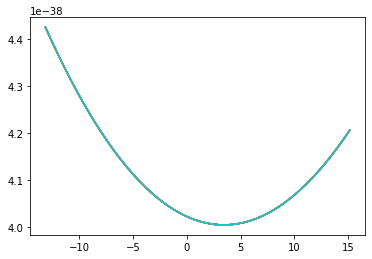

In [11]:
dataset.fake(background_model=bkg) #realization
fivesigma = 5*dataset.nuissance["sigmaj"].value
jlo = dataset.nuissance["jobs"].value - fivesigma
jhi = dataset.nuissance["jobs"].value + fivesigma
    
for ji in np.linspace(jlo, jhi, 10):
    dataset.set_j(ji * JFAC.unit)
    print(dataset.jnuissance())
    fit = Fit(dataset)
    fit_result = fit.run()
    likelihood_profile_opts=dict(bounds=10, nvalues=50)
    likelihood_profile_opts["parameter"] = "sv"
    profile = fit.likelihood_profile(**likelihood_profile_opts)
    plt.plot(profile["values"], profile["likelihood"]);